# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [56]:
# Imports
import os.path
import math
import random
import shutil
import glob
import PIL
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib

In [57]:
# Constants
CURRENT_DIRECTORY = '.'
TEMP_DIRECTORY = './tmp/'
RANDRANGE_STOP = 10000
EPOCHS = 100
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 255.0
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 64
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

In [58]:
# Check if Tensorflow is using GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Prepocessing

In [59]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    testDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(testDirPre):
        if not os.path.isdir(TEST_FOLDER):
            shutil.move(testDirPre, CURRENT_DIRECTORY)
        
    return topDir, TEST_FOLDER

In [60]:
# Pre Process Images
trainFolder, testFolder = DownloadImageSet()

In [61]:
testImgPaths = glob.glob('{}/*.{}'.format(testFolder, IMAGE_EXTENSION))

In [62]:
def ImageNorm(image):
    image = image/RESCALE_FACTOR
    return image

In [63]:
def Shrink(input):
    return tf.image.resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [64]:
trainSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


In [65]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [66]:
for batch in trainSet.take(1):
    hiResSample = array_to_img(batch[1][0])
    lowResSample = array_to_img(batch[0][0])
bicubicSample = lowResSample.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=PIL.Image.BICUBIC)

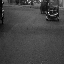

In [67]:
display(hiResSample)

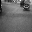

In [68]:
display(lowResSample)

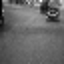

In [69]:
display(bicubicSample)

In [70]:
valSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [71]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Utility Functions

In [72]:
def plotResults(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(TEMP_DIRECTORY + str(prefix) + "-" + title + ".png")
    plt.show()

In [73]:
def getLowresImage(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )

In [74]:

def upscaleImage(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [75]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = getLowresImage(load_img(testImgPaths[0]), UPSCALE_FACTOR)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscaleImage(self.model, self.test_img)
            plotResults(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [76]:
earlyStoppingCallback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

modelCheckpointCallback = keras.callbacks.ModelCheckpoint(
    filepath=TEMP_DIRECTORY,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

callbacks = [ESPCNCallback(), earlyStoppingCallback, modelCheckpointCallback]

## Create Model

In [77]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=9, activation='relu', kernel_initializer='Orthogonal', padding='same')(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=5, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [78]:
sr = SuperResolution()
sr.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 4)     3204      
_________________________________________________________________
tf.nn.depth_to_space_4 (TFOp (None, None, None, 1)     0         
Total params: 10,532
Trainable params: 10,532
Non-trainable params: 0
_________________________________________________________________


In [79]:
def XingyuLong(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):
    convArgs = {
        'activation': 'relu',
        'kernel_initializer': 'Orthogonal',
        'padding': 'same'
    }

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=5, **convArgs)(inputs)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, **convArgs)(x)
    x = keras.layers.Conv2D(filters=32, kernel_size=3, **convArgs)(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=3, **convArgs)(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [80]:
xl = XingyuLong()
xl.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 4)     1156      
_________________________________________________________________
tf.nn.depth_to_space_5 (TFOp (None, None, None, 1)     0         
Total params: 58,212
Trainable params: 58,212
Non-trainable params: 0
_______________________________________________________

## Train the Model

In [81]:
opt = keras.optimizers.SGD(learning_rate=0.001)
lossFn = keras.losses.MeanSquaredError()

Epoch 1/100
65/65 [==============================] - 6s 87ms/step - loss: 0.2159 - val_loss: 0.2183
Mean PSNR for epoch: 6.67


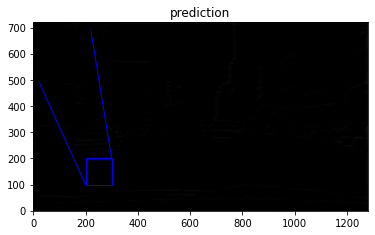

./tmp\
Epoch 2/100
65/65 [==============================] - 6s 85ms/step - loss: 0.1985 - val_loss: 0.1802
Mean PSNR for epoch: 7.50
./tmp\
Epoch 3/100
65/65 [==============================] - 6s 89ms/step - loss: 0.1699 - val_loss: 0.1735
Mean PSNR for epoch: 7.56
./tmp\
Epoch 4/100
65/65 [==============================] - 6s 87ms/step - loss: 0.1575 - val_loss: 0.1352
Mean PSNR for epoch: 8.66
./tmp\
Epoch 5/100
65/65 [==============================] - 6s 87ms/step - loss: 0.1280 - val_loss: 0.1311
Mean PSNR for epoch: 8.62
./tmp\
Epoch 6/100
65/65 [==============================] - 6s 86ms/step - loss: 0.1267 - val_loss: 0.1304
Mean PSNR for epoch: 8.91
./tmp\
Epoch 7/100
65/65 [==============================] - 6s 87ms/step - loss: 0.1261 - val_loss: 0.1299
Mean PSNR for epoch: 8.86
./tmp\
Epoch 8/100
65/65 [==============================] - 6s 87ms/step - loss: 0.1235 - val_loss: 0.1294
Mean PSNR for epoch: 9.21
./tmp\
Epoch 9/100
65/65 [==============================] - 6s 86ms/s

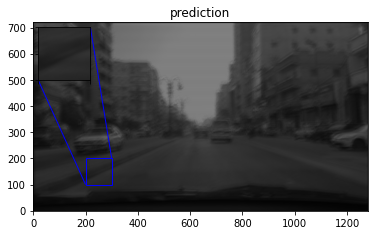

./tmp\
Epoch 22/100
65/65 [==============================] - 6s 88ms/step - loss: 0.1201 - val_loss: 0.1242
Mean PSNR for epoch: 8.98
./tmp\
Epoch 23/100
65/65 [==============================] - 6s 88ms/step - loss: 0.1170 - val_loss: 0.1175
Mean PSNR for epoch: 9.27
./tmp\
Epoch 24/100
65/65 [==============================] - 6s 88ms/step - loss: 0.1032 - val_loss: 0.0825
Mean PSNR for epoch: 10.84
./tmp\
Epoch 25/100
65/65 [==============================] - 6s 87ms/step - loss: 0.0775 - val_loss: 0.0783
Mean PSNR for epoch: 11.17
./tmp\
Epoch 26/100
65/65 [==============================] - 6s 87ms/step - loss: 0.0752 - val_loss: 0.0777
Mean PSNR for epoch: 11.23
./tmp\
Epoch 27/100
65/65 [==============================] - 6s 88ms/step - loss: 0.0748 - val_loss: 0.0773
Mean PSNR for epoch: 11.07
./tmp\
Epoch 28/100
65/65 [==============================] - 6s 88ms/step - loss: 0.0738 - val_loss: 0.0770
Mean PSNR for epoch: 11.22
./tmp\
Epoch 29/100
65/65 [==============================

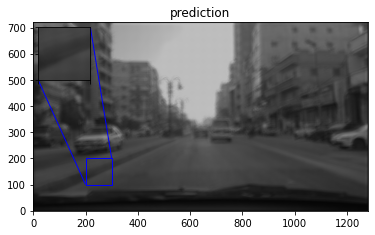

./tmp\
Epoch 42/100
65/65 [==============================] - 6s 90ms/step - loss: 0.0711 - val_loss: 0.0739
Mean PSNR for epoch: 11.33
./tmp\
Epoch 43/100
65/65 [==============================] - 6s 89ms/step - loss: 0.0714 - val_loss: 0.0737
Mean PSNR for epoch: 11.17
./tmp\
Epoch 44/100
65/65 [==============================] - 6s 91ms/step - loss: 0.0708 - val_loss: 0.0736
Mean PSNR for epoch: 11.33
./tmp\
Epoch 45/100
65/65 [==============================] - 6s 90ms/step - loss: 0.0707 - val_loss: 0.0734
Mean PSNR for epoch: 11.42
./tmp\
Epoch 46/100
65/65 [==============================] - 6s 89ms/step - loss: 0.0705 - val_loss: 0.0733
Mean PSNR for epoch: 11.30
./tmp\
Epoch 47/100
65/65 [==============================] - 6s 89ms/step - loss: 0.0705 - val_loss: 0.0731
Mean PSNR for epoch: 11.37
./tmp\
Epoch 48/100
65/65 [==============================] - 6s 91ms/step - loss: 0.0691 - val_loss: 0.0730
Mean PSNR for epoch: 11.36
./tmp\
Epoch 49/100
65/65 [============================

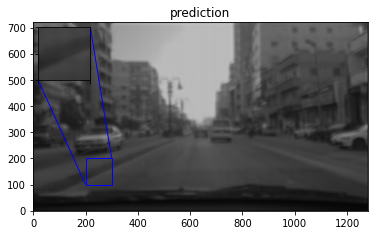

./tmp\
Epoch 62/100
65/65 [==============================] - 6s 88ms/step - loss: 0.0696 - val_loss: 0.0715
Mean PSNR for epoch: 11.37
./tmp\
Epoch 63/100
65/65 [==============================] - 6s 87ms/step - loss: 0.0684 - val_loss: 0.0714
Mean PSNR for epoch: 11.60
./tmp\
Epoch 64/100
65/65 [==============================] - 6s 88ms/step - loss: 0.0688 - val_loss: 0.0713
Mean PSNR for epoch: 11.45
./tmp\
Epoch 65/100
65/65 [==============================] - 6s 88ms/step - loss: 0.0689 - val_loss: 0.0712
Mean PSNR for epoch: 11.31
./tmp\
Epoch 66/100
65/65 [==============================] - 6s 89ms/step - loss: 0.0685 - val_loss: 0.0711
Mean PSNR for epoch: 11.43
./tmp\
Epoch 67/100
65/65 [==============================] - 6s 88ms/step - loss: 0.0684 - val_loss: 0.0710
Mean PSNR for epoch: 11.57
./tmp\
Epoch 68/100
65/65 [==============================] - 6s 93ms/step - loss: 0.0686 - val_loss: 0.0709
Mean PSNR for epoch: 11.51
./tmp\
Epoch 69/100
65/65 [============================

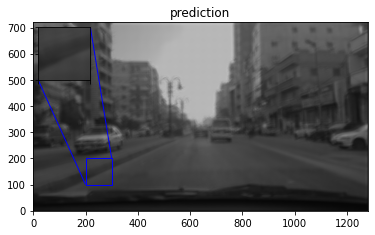

./tmp\
Epoch 82/100
65/65 [==============================] - 6s 92ms/step - loss: 0.0674 - val_loss: 0.0700
Mean PSNR for epoch: 11.68
./tmp\
Epoch 83/100
65/65 [==============================] - 7s 93ms/step - loss: 0.0674 - val_loss: 0.0699
Mean PSNR for epoch: 11.50
./tmp\
Epoch 84/100
65/65 [==============================] - 6s 91ms/step - loss: 0.0672 - val_loss: 0.0698
Mean PSNR for epoch: 11.55
./tmp\
Epoch 85/100
65/65 [==============================] - 6s 93ms/step - loss: 0.0670 - val_loss: 0.0698
Mean PSNR for epoch: 11.66
./tmp\
Epoch 86/100
65/65 [==============================] - 6s 90ms/step - loss: 0.0674 - val_loss: 0.0697
Mean PSNR for epoch: 11.53
./tmp\
Epoch 87/100
65/65 [==============================] - 6s 91ms/step - loss: 0.0668 - val_loss: 0.0697
Mean PSNR for epoch: 11.68
./tmp\
Epoch 88/100
65/65 [==============================] - 6s 90ms/step - loss: 0.0667 - val_loss: 0.0696
Mean PSNR for epoch: 11.64
./tmp\
Epoch 89/100
65/65 [============================

In [82]:
sr.compile(optimizer=opt, loss=lossFn)
sr.fit(trainSet, epochs=EPOCHS, callbacks=callbacks, validation_data=valSet, use_multiprocessing=True, verbose=1)

Epoch 1/100
65/65 [==============================] - 7s 98ms/step - loss: 0.2002 - val_loss: 0.1840
Mean PSNR for epoch: 7.35


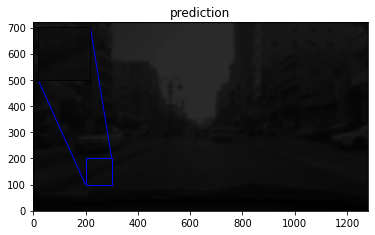

Epoch 2/100
65/65 [==============================] - 7s 99ms/step - loss: 0.1720 - val_loss: 0.1771
Mean PSNR for epoch: 7.43
Epoch 3/100
65/65 [==============================] - 7s 98ms/step - loss: 0.1692 - val_loss: 0.1755
Mean PSNR for epoch: 7.70
Epoch 4/100
65/65 [==============================] - 7s 98ms/step - loss: 0.1683 - val_loss: 0.1746
Mean PSNR for epoch: 7.56
Epoch 5/100
65/65 [==============================] - 7s 94ms/step - loss: 0.1682 - val_loss: 0.1720
Mean PSNR for epoch: 7.76
Epoch 6/100
65/65 [==============================] - 7s 95ms/step - loss: 0.1604 - val_loss: 0.1433
Mean PSNR for epoch: 8.23
Epoch 7/100
65/65 [==============================] - 7s 95ms/step - loss: 0.1314 - val_loss: 0.1282
Mean PSNR for epoch: 9.03
Epoch 8/100
65/65 [==============================] - 7s 96ms/step - loss: 0.1218 - val_loss: 0.1239
Mean PSNR for epoch: 9.03
Epoch 9/100
65/65 [==============================] - 7s 98ms/step - loss: 0.1180 - val_loss: 0.1114
Mean PSNR for epoc

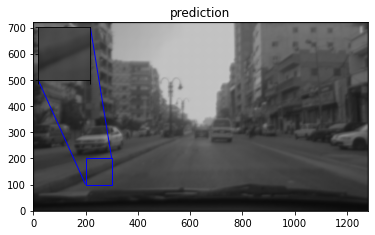

Epoch 22/100
65/65 [==============================] - 7s 99ms/step - loss: 0.0472 - val_loss: 0.0296
Mean PSNR for epoch: 15.19
./tmp\
Epoch 23/100
65/65 [==============================] - 7s 99ms/step - loss: 0.0267 - val_loss: 0.0244
Mean PSNR for epoch: 16.14
./tmp\
Epoch 24/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0230 - val_loss: 0.0232
Mean PSNR for epoch: 16.34
./tmp\
Epoch 25/100
65/65 [==============================] - 7s 99ms/step - loss: 0.0219 - val_loss: 0.0227
Mean PSNR for epoch: 16.42
./tmp\
Epoch 26/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0217 - val_loss: 0.0224
Mean PSNR for epoch: 16.73
./tmp\
Epoch 27/100
65/65 [==============================] - 7s 99ms/step - loss: 0.0211 - val_loss: 0.0221
Mean PSNR for epoch: 16.57
./tmp\
Epoch 28/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0209 - val_loss: 0.0219
Mean PSNR for epoch: 16.71
./tmp\
Epoch 29/100
65/65 [==============================] 

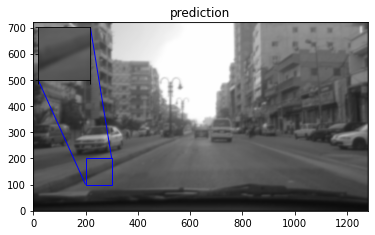

./tmp\
Epoch 42/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0183 - val_loss: 0.0192
Mean PSNR for epoch: 17.18
./tmp\
Epoch 43/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0181 - val_loss: 0.0190
Mean PSNR for epoch: 17.14
./tmp\
Epoch 44/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0183 - val_loss: 0.0189
Mean PSNR for epoch: 17.30
./tmp\
Epoch 45/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0181 - val_loss: 0.0188
Mean PSNR for epoch: 17.31
./tmp\
Epoch 46/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0179 - val_loss: 0.0186
Mean PSNR for epoch: 17.20
./tmp\
Epoch 47/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0178 - val_loss: 0.0185
Mean PSNR for epoch: 17.41
./tmp\
Epoch 48/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0177 - val_loss: 0.0184
Mean PSNR for epoch: 17.47
./tmp\
Epoch 49/100
65/65 [=====================

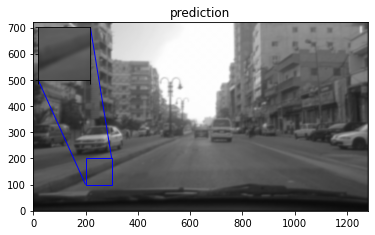

./tmp\
Epoch 62/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0165 - val_loss: 0.0170
Mean PSNR for epoch: 17.84
./tmp\
Epoch 63/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0163 - val_loss: 0.0169
Mean PSNR for epoch: 17.84
./tmp\
Epoch 64/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0164 - val_loss: 0.0168
Mean PSNR for epoch: 17.88
./tmp\
Epoch 65/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0161 - val_loss: 0.0167
Mean PSNR for epoch: 17.84
./tmp\
Epoch 66/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0161 - val_loss: 0.0167
Mean PSNR for epoch: 17.71
./tmp\
Epoch 67/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0161 - val_loss: 0.0166
Mean PSNR for epoch: 17.67
./tmp\
Epoch 68/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0159 - val_loss: 0.0165
Mean PSNR for epoch: 17.97
./tmp\
Epoch 69/100
65/65 [=====================

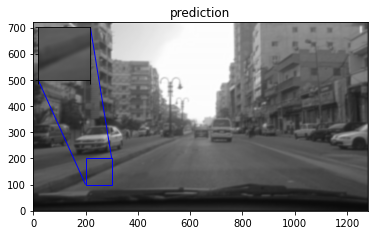

./tmp\
Epoch 82/100
65/65 [==============================] - 7s 100ms/step - loss: 0.0150 - val_loss: 0.0156
Mean PSNR for epoch: 18.19
./tmp\
Epoch 83/100
65/65 [==============================] - 7s 102ms/step - loss: 0.0149 - val_loss: 0.0155
Mean PSNR for epoch: 17.99
./tmp\
Epoch 84/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0150 - val_loss: 0.0154
Mean PSNR for epoch: 18.26
./tmp\
Epoch 85/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0150 - val_loss: 0.0154
Mean PSNR for epoch: 18.18
./tmp\
Epoch 86/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0149 - val_loss: 0.0153
Mean PSNR for epoch: 18.16
./tmp\
Epoch 87/100
65/65 [==============================] - 7s 101ms/step - loss: 0.0149 - val_loss: 0.0153
Mean PSNR for epoch: 18.14
./tmp\
Epoch 88/100
65/65 [==============================] - 7s 102ms/step - loss: 0.0149 - val_loss: 0.0152
Mean PSNR for epoch: 18.16
./tmp\
Epoch 89/100
65/65 [=====================

In [83]:
xl.compile(optimizer=opt, loss=lossFn)
xl.fit(trainSet, epochs=EPOCHS, callbacks=callbacks, validation_data=valSet, use_multiprocessing=True, verbose=1)

## Test the Model

In [84]:
def MagnifyImage(model, lowResImg):
    lowResArr = img_to_array(lowResImg)
    lowResArr = lowResArr.astype('float32')/RESCALE_FACTOR
    input = np.expand_dims(lowResArr, axis=0)
    out = model.predict(input)
    out *= RESCALE_FACTOR
    out = out.reshape((ORIG_IMG_SIZE,ORIG_IMG_SIZE,CHANNELS))
    out = array_to_img(x=out)
    return out

In [85]:
for idx, testImgPath in enumerate(testImgPaths):
    if idx > 0:
        continue
    img = load_img(testImgPath, color_mode='grayscale', target_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE))
    lowResImg = img.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE), resample=PIL.Image.BICUBIC)
    biCubicImg = img.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=PIL.Image.BICUBIC)
    superResImg = MagnifyImage(sr,lowResImg)
    xlImg = MagnifyImage(xl,lowResImg)

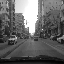

In [86]:
display(img)

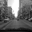

In [87]:
display(lowResImg)

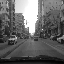

In [88]:
display(biCubicImg)

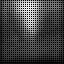

In [89]:
display(superResImg)

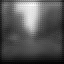

In [90]:
display(xlImg)